In [1]:
%matplotlib inline
import scipy
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# custom libraries used
from models.grid_world import Experiment
from models.agents import IndependentClusterAgent, JointClusteringAgent, FlatAgent, MetaAgent
from models.experiment_designs.experiment2 import gen_task_param


In [2]:
n_sims = 114

# alpha is sample from the distribution
# log(alpha) ~ N(alpha_mu, alpha_scale)
alpha_mu = 0.0
alpha_scale = 1.0

inv_temp = 2.5
goal_prior = 10e-20 
prunning_threshold = 10.0
evaluate = True

np.random.seed(11223344)

# pre generate a set of tasks for consistency. 
list_tasks = [gen_task_param() for _ in range(n_sims)]

# pre draw the alphas for consistency
list_alpha = [np.exp(scipy.random.normal(loc=alpha_mu, scale=alpha_scale)) 
              for _ in range(n_sims)]

def sim_agent(AgentClass, name='None', flat=False, meta=False):
    results = []
    for ii, (task_args, task_kwargs) in tqdm(enumerate(list_tasks), total=len(list_tasks)):

        if not flat:
            agent_kwargs = dict(alpha=list_alpha[ii], inv_temp=inv_temp, 
                                goal_prior=goal_prior)
        else:
            agent_kwargs = dict(inv_temp=inv_temp, goal_prior=goal_prior)
            
        if meta:
            agent_kwargs['mix_biases'] = [np.random.uniform(-7, 0), np.random.uniform(-7, 0)]
        
        agent = AgentClass(Experiment(*task_args, **task_kwargs), **agent_kwargs)
        
        _res = agent.generate(evaluate=evaluate, prunning_threshold=prunning_threshold)
        _res[u'Model'] = name
        _res[u'Iteration'] = [ii] * len(_res)
        results.append(_res)
    return pd.concat(results)

In [3]:
results_ic = sim_agent(IndependentClusterAgent, name='Independent')
results_jc = sim_agent(JointClusteringAgent, name='Joint')
results_fl = sim_agent(FlatAgent, name='Flat', flat=True)
results_meta = sim_agent(MetaAgent, name='Meta', meta=True)
results = pd.concat([results_ic, results_jc, results_fl, results_meta])

HBox(children=(IntProgress(value=0, max=114), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=114), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=114), HTML(value=u'')))

HBox(children=(IntProgress(value=0, max=114), HTML(value=u'')))

In [4]:
results = pd.concat([results_ic, results_jc, results_fl, results_meta])

## Model Predictions
Summary Statistics:

In [5]:
results['Training'] = results.Context < 8
results['Acc'] = pd.to_numeric(results.Reward)
results[results['In Goal']].groupby(['Training', 'Model']).mean()

Context  Goal KL Divergence  In Goal  Ind Weight  \
Training Model                                                            
False    Flat         9.000000            1.017596     True         NaN   
         Independent  9.000000            2.066814     True         NaN   
         Joint        9.000000            2.180465     True         NaN   
         Meta         9.000000            1.680621     True  -67.669257   
True     Flat         3.927711            0.404052     True         NaN   
         Independent  3.927711            0.871781     True         NaN   
         Joint        3.927711            0.725575     True         NaN   
         Meta         3.927711            0.735039     True  -36.602027   

                      Iteration  Joint Probability  Joint Weight  Key-press  \
Training Model                                                                
False    Flat              56.5                NaN           NaN   2.853314   
         Independent       56.5                NaN           NaN   2.833333   
         Joint             56.5                NaN           NaN   2.868908   
         Meta              56.5           0.692605    -55.530268   2.844055   
True     Flat              56.5                NaN           NaN   3.565789   
         Independent       56.5                NaN           NaN   3.573769   
         Joint             56.5                NaN           NaN   3.574297   
         Meta              56.5           0.608358    -31.860093   3.571655   

                      Map KL Divergence  Steps Taken  Times Seen Context  \
Training Model                                                             
False    Flat                  1.082724    11.740741            3.500000   
         Independent           0.238258     9.168616            3.500000   
         Joint                 0.507381    10.147173            3.500000   
         Meta                  0.366625     9.992690            3.500000   
True     Flat                  0.305947     8.090044           14.463855   
         Independent           0.154860     8.156257           14.463855   
         Joint                 0.204187     7.942930           14.463855   
         Meta                  0.191405     7.990330           14.463855   

                      Trial Number       Acc  
Training Model                                
False    Flat           171.504873  0.661793  
         Independent    171.504873  0.505361  
         Joint          171.504873  0.587719  
         Meta           171.504873  0.579435  
True     Flat            82.824773  0.899968  
         Independent     82.824773  0.784348  
         Joint           82.824773  0.860917  
         Meta            82.824773  0.847495

In [6]:
results['Training'] = results.Context < 8
results['Acc'] = pd.to_numeric(results.Reward)
results[results['In Goal']].groupby(['Model']).mean()

,Context,Goal KL Divergence,In Goal,Ind Weight,Iteration,Joint Probability,Joint Weight,Key-press,Map KL Divergence,Steps Taken,Times Seen Context,Trial Number,Training,Acc
Model,,,,,,,,,,,,,,
Flat,4.423913,0.464073,1.0,NaN,56.5,NaN,NaN,3.496091,0.381936,8.447178,13.391304,91.5,0.902174,0.876669
Independent,4.423913,0.988687,1.0,NaN,56.5,NaN,NaN,3.501335,0.163019,8.255292,13.391304,91.5,0.902174,0.757056
Joint,4.423913,0.867901,1.0,NaN,56.5,NaN,NaN,3.505292,0.233847,8.158562,13.391304,91.5,0.902174,0.834191
Meta,4.423913,0.827542,1.0,-39.641213,56.5,0.6166,-34.175654,3.500477,0.208546,8.186213,13.391304,91.5,0.902174,0.821272


Plot the overall rewards collected in the training and test contexts

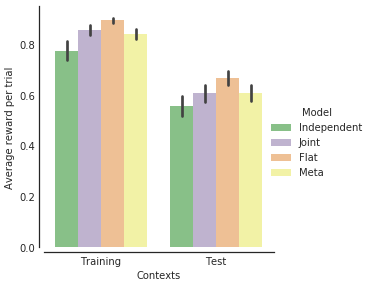

In [7]:
in_goal = results[results['In Goal'] ].copy()
in_goal['Contexts'] = [None] * len(in_goal)
in_goal.loc[in_goal.Context < 6, 'Contexts'] = 'Training'
in_goal.loc[in_goal.Context >= 7, 'Contexts'] = 'Test'

with sns.axes_style('white'):
    g = sns.factorplot(y='Reward', data=in_goal, x='Contexts', 
                   hue='Model', units='Iteration', kind='bar', 
                   estimator=np.mean, palette='Accent', size=4)
    sns.despine(offset=5, trim=False)
    ax = g.axes[0][0]
    ax.set_ylabel('Average reward per trial')

Break down the accuracy in each test context

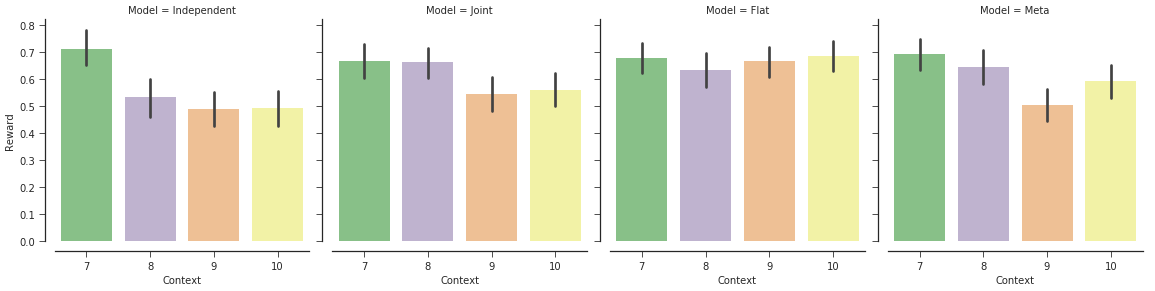

In [8]:
with sns.axes_style('ticks'):
    sns.factorplot(x='Context', y='Reward', data=in_goal[in_goal['Contexts'] == 'Test'], 
                   kind='bar', palette='Accent', col='Model', units='Iteration')
    g.set_xlabels(['T1', 'T2', 'T3', 'T4'])
    sns.despine(offset=10)

# Paper Figure
*Left*: Reward collected in test contexts across time

*Right*: Difference in reward collect between contexts across equated trials

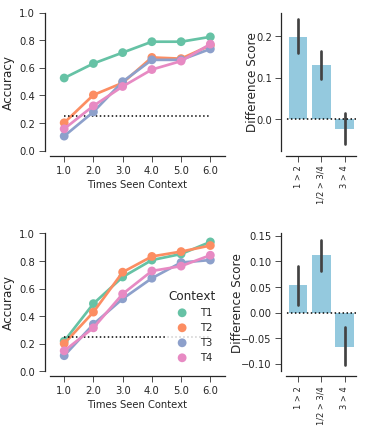

In [10]:
from matplotlib import gridspec

# plot the difference scores
df0 = results[results['In Goal'] & (results.Context >= 7) &
              (results['Model'] != 'Flat')
             ].copy()

score = list()
for m in set(df0.Model):
    for it in set(df0.Iteration):
        subj_df = df0.loc[(df0.Model == m) & (df0.Iteration == it), :]
                
        diff_1 = subj_df.loc[subj_df.Context == 7, :
                            ].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 8) | (subj_df.Context == 10), :
                       ].groupby('Times Seen Context').mean()['Acc']

        diff_2 = subj_df.loc[(subj_df.Context == 7) | (subj_df.Context == 8), :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 9) | (subj_df.Context == 10), :].groupby('Times Seen Context').mean()['Acc']

        diff_3 = subj_df.loc[subj_df.Context == 9, :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 8) | (subj_df.Context == 10), :].groupby('Times Seen Context').mean()['Acc']


        n = len(diff_1)
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T1 vs T2'] * n,
                    'Difference Score': diff_1,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T1+2 vs T3+4'] * n,
                    'Difference Score': diff_2,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T3 vs T4'] * n,
                    'Difference Score': diff_3,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))

score = pd.concat(score) 

df0 = results[results['In Goal'] & (results.Context >= 7) ].copy()
df0['Context'] += 1

with sns.axes_style('ticks'):
    fig  = plt.figure(figsize=(5.5, 6.6))
    gs = gridspec.GridSpec(2, 2, width_ratios=[2.5, 1], wspace=0.5, hspace=0.6)
    axes = [
        [plt.subplot(gs[0]), plt.subplot(gs[1])],
        [plt.subplot(gs[2]),  plt.subplot(gs[3])]
    ]
    
    sns.pointplot(x = 'Times Seen Context', hue='Context', y='Reward', ci=None,
                   data=df0[df0.Model=='Independent'],  palette='Set2', ax=axes[0][0])
    sns.pointplot(x = 'Times Seen Context', hue='Context', y='Reward', ci=None,
                   data=df0[df0.Model=='Joint'],  palette='Set2', ax=axes[1][0])
    
    axes[0][0].legend_.remove() 
    ax = axes[1][0]
    handles, labels = ax.get_legend_handles_labels()
    handles[0].set_label('T1')
    handles[1].set_label('T2')
    handles[2].set_label('T3')
    handles[3].set_label('T4')
    legend = ax.legend(title="Context", loc='lower right', frameon=1)
    legend.get_frame().set_edgecolor('w')
    ax.get_legend().get_title().set_fontsize(12)
    
    
    # plot difference scores on the right
    
    
    sns.barplot(x='Comparison', y='Difference Score', 
            data=score[score.Model == 'Independent'], color='skyblue', ax=axes[0][1])
    sns.barplot(x='Comparison', y='Difference Score',
            data=score[score.Model == 'Joint'], color='skyblue', ax=axes[1][1])
    
    for ii in [0, 1]:
        ax = axes[ii][0]
        ax.set_ylabel(r'Accuracy',  fontdict={'size':12})
        ax.plot([0, 5], [0.25, 0.25], 'k:')
        ax.set_ylim([0, 1])
    
    sns.despine(offset=5)

    for ii in [0, 1]:
        ax = axes[ii][1]
        ax.set_ylabel(r'Difference Score', labelpad=-3, fontdict={'size':12})
        ax.set_xlabel('')
        ax.plot([-1, 3], [0, 0], 'k:')
        plt.sca(ax)
        plt.xticks([0, 1, 2], [r'1 > 2', u'1/2 > 3/4', r'3 > 4' ], rotation='vertical',
                  fontsize='small')
        
    plt.savefig('Exp2_fig1.png', dpi=300)

In [41]:
df1 = score.groupby(['Model', 'Comparison','Iteration']).sum().reset_index()
print df1.groupby(['Model', 'Comparison']).mean().reset_index()
print df1.groupby(['Model', 'Comparison']).std().reset_index()

         Model    Comparison  Iteration  Difference Score  Trials in Context
0  Independent      T1 vs T2       56.5          1.192982               15.0
1  Independent  T1+2 vs T3+4       56.5          0.789474               15.0
2  Independent      T3 vs T4       56.5         -0.140351               15.0
3        Joint      T1 vs T2       56.5          0.328947               15.0
4        Joint  T1+2 vs T3+4       56.5          0.671053               15.0
5        Joint      T3 vs T4       56.5         -0.407895               15.0
6         Meta      T1 vs T2       56.5          0.442982               15.0
7         Meta  T1+2 vs T3+4       56.5          0.719298               15.0
8         Meta      T3 vs T4       56.5         -0.688596               15.0
         Model    Comparison  Iteration  Difference Score  Trials in Context
0  Independent      T1 vs T2  33.052988          2.348516                0.0
1  Independent  T1+2 vs T3+4  33.052988          1.839698                0.0

In [31]:
m = 'Joint'
df0 = results[results['In Goal'] & (results.Context >= 7) &
              (results['Model'] != 'Flat')
             ].copy()
for it in set(df0.Iteration):
    subj_df = df0.loc[(df0.Model == m) & (df0.Iteration == it), :]
    diff_1 = subj_df.loc[subj_df.Context == 7, :
                            ].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 8) | (subj_df.Context == 10), :
                       ].groupby('Times Seen Context').mean()['Acc']
    print diff_1

Times Seen Context
1.0    0.0
2.0    0.0
3.0    0.5
4.0    0.0
5.0    0.0
6.0    0.0
Name: Acc, dtype: float64
Times Seen Context
1.0    0.0
2.0   -0.5
3.0   -1.0
4.0   -1.0
5.0   -1.0
6.0   -1.0
Name: Acc, dtype: float64
Times Seen Context
1.0   -0.5
2.0   -0.5
3.0    0.0
4.0    0.0
5.0   -1.0
6.0    0.0
Name: Acc, dtype: float64
Times Seen Context
1.0    0.0
2.0    0.0
3.0   -0.5
4.0    0.5
5.0    0.0
6.0    0.5
Name: Acc, dtype: float64
Times Seen Context
1.0    0.0
2.0    0.0
3.0   -0.5
4.0    0.0
5.0    0.0
6.0    0.0
Name: Acc, dtype: float64
Times Seen Context
1.0    1.0
2.0    1.0
3.0    0.5
4.0    0.5
5.0    0.5
6.0    0.5
Name: Acc, dtype: float64
Times Seen Context
1.0    0.0
2.0    0.0
3.0    0.5
4.0    0.5
5.0    0.5
6.0    0.5
Name: Acc, dtype: float64
Times Seen Context
1.0    1.0
2.0    0.5
3.0    0.5
4.0    0.5
5.0    0.0
6.0    0.0
Name: Acc, dtype: float64
Times Seen Context
1.0    0.0
2.0    1.0
3.0    1.0
4.0    0.5
5.0    0.5
6.0    0.0
Name: Acc, dtype: float64
T

Times Seen Context
1.0   -1.0
2.0   -1.0
3.0   -1.0
4.0   -1.0
5.0   -1.0
6.0    0.0
Name: Acc, dtype: float64
Times Seen Context
1.0    0.0
2.0    0.5
3.0    0.0
4.0    0.0
5.0    0.0
6.0    0.0
Name: Acc, dtype: float64
Times Seen Context
1.0   -0.5
2.0    0.0
3.0   -0.5
4.0   -0.5
5.0   -0.5
6.0   -0.5
Name: Acc, dtype: float64
Times Seen Context
1.0    0.0
2.0    0.0
3.0    0.0
4.0    0.0
5.0    0.5
6.0    0.0
Name: Acc, dtype: float64
Times Seen Context
1.0    0.0
2.0    0.0
3.0    0.5
4.0    0.5
5.0    0.5
6.0    0.5
Name: Acc, dtype: float64
Times Seen Context
1.0    0.0
2.0    1.0
3.0    0.0
4.0    0.0
5.0    0.0
6.0    0.0
Name: Acc, dtype: float64
Times Seen Context
1.0    0.0
2.0    1.0
3.0    0.5
4.0    0.5
5.0    0.5
6.0    0.0
Name: Acc, dtype: float64
Times Seen Context
1.0   -0.5
2.0   -0.5
3.0   -1.0
4.0    0.0
5.0   -1.0
6.0    0.0
Name: Acc, dtype: float64
Times Seen Context
1.0    0.0
2.0   -0.5
3.0    0.5
4.0    0.0
5.0    0.0
6.0    0.0
Name: Acc, dtype: float64
T

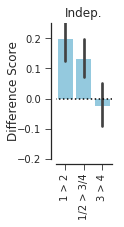

In [27]:
def plot_contrasts(model, model_name):
    with sns.axes_style('ticks'):
        fig, ax  = plt.subplots(figsize=(1.0, 2.5))    # plot difference scores on the right
        sns.barplot(x='Comparison', y='Difference Score', units='Iteration',
                data=score[score.Model == model], color='skyblue', ax=ax)
        ax.set_ylabel(r'Difference Score', labelpad=-3, fontdict={'size':12})
        ax.set_xlabel('')
        ax.plot([-1, 3], [0, 0], 'k:')
        ax.set_ylim([-0.2, 0.251])
        ax.set_yticks(np.arange(-0.2, 0.251, 0.1))
        sns.despine(offset=5)

        plt.xticks([0, 1, 2], [r'1 > 2', u'1/2 > 3/4', r'3 > 4' ], rotation='vertical')
        ax.set_title(model_name)
    return fig 
fig = plot_contrasts('Independent', 'Indep.')
fig.savefig('Exp2_fig_model1.png', dpi=300, bbox_inches='tight')

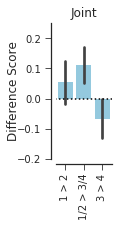

In [28]:
fig = plot_contrasts('Joint', 'Joint')
fig.savefig('Exp2_fig_model2.png', dpi=300, bbox_inches='tight')

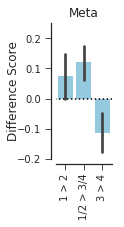

In [29]:
fig = plot_contrasts('Meta', 'Meta')
fig.savefig('Exp2_fig_model3.png', dpi=300, bbox_inches='tight')

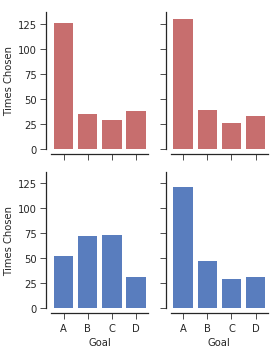

In [14]:
df0 = results[results['In Goal'] & (results.Context > 6) & 
               (results['Times Seen Context'] == 1) 
             & (results['Model'] != 'Flat')].copy()
df0['Map'] = ['1'] * len(df0)
df0.loc[(df0.Context == 7) | (df0.Context == 8), 'Map'] = 1
df0.loc[(df0.Context == 9) | (df0.Context == 10), 'Map'] = 2

cmap = "BrBG"
n = 3
# cc = [sns.color_palette(cmap, n_colors=16)[n], sns.color_palette(cmap, n_colors=16)[-(1+n)]]
cc = sns.color_palette('muted')
with sns.axes_style('ticks'):
    df0['Chosen'] = [1] * len(df0)
    fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(4, 5))
    
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Joint') & (df0.Map == 2)], ax=axes[0][0], color=cc[2])
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Joint') & (df0.Map == 1)], ax=axes[1][0], color=cc[0]) 
    
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Independent') & (df0.Map == 2)], ax=axes[0][1], color=cc[2])
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Independent') & (df0.Map == 1)], ax=axes[1][1], color=cc[0]) 
    
    for ii in [0, 1]:
        ax = axes[ii][0]
        ax.set_ylabel('Times Chosen')
        
        ax = axes[ii][1]
        ax.set_ylabel('')

        ax = axes[1][ii]
        ax.set_xlabel('Goal')

        ax = axes[0][ii]
        ax.set_xlabel('')

    sns.despine(offset=5)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    plt.tight_layout()
    plt.savefig('Exp2_fig2.png', dpi=300)

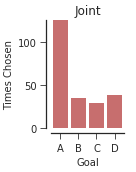

In [15]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 1, sharey=True, figsize=(2.0, 2.5))

    cc = sns.color_palette('muted')
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Joint') & (df0.Map == 2)], ax=ax, color=cc[2])
    
    ax.set_ylabel('Times Chosen')
    ax.set_xlabel('Goal')
    ax.set_title(r'Joint')
    ax.set_yticks([0,50,100])
    ax.set_ylim([0, 125])

    sns.despine(offset=5)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    plt.tight_layout()
    plt.savefig('exp2_qual1_joint.png', dpi=300, bbox_inches='tight')

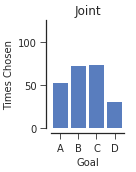

In [16]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 1, sharey=True, figsize=(2.0, 2.5))

    cc = sns.color_palette('muted')
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Joint') & (df0.Map == 1)], ax=ax, color=cc[0])
    
    ax.set_ylabel('Times Chosen')
    ax.set_xlabel('Goal')
    ax.set_title(r'Joint')
    ax.set_yticks([0,50,100])
    ax.set_ylim([0, 125])

    sns.despine(offset=5)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    plt.tight_layout()
    plt.savefig('exp2_qual2_joint.png', dpi=300, bbox_inches='tight')

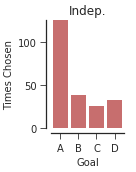

In [17]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 1, sharey=True, figsize=(2.0, 2.5))

    cc = sns.color_palette('muted')
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Independent') & (df0.Map == 2)], ax=ax, color=cc[2])
    
    ax.set_ylabel('Times Chosen')
    ax.set_xlabel('Goal')
    ax.set_title(r'Indep.')
    ax.set_yticks([0,50,100])
    ax.set_ylim([0, 125])
    sns.despine(offset=5)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    
    plt.tight_layout()
    plt.savefig('exp2_qual1_indep.png', dpi=300, bbox_inches='tight')

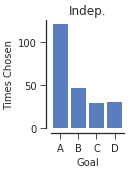

In [18]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 1, sharey=True, figsize=(2.0, 2.5))

    cc = sns.color_palette('muted')
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Independent') & (df0.Map == 1)], ax=ax, color=cc[0])
    
    ax.set_ylabel('Times Chosen')
    ax.set_xlabel('Goal')
    ax.set_title(r'Indep.')
    ax.set_yticks([0,50,100])
    ax.set_ylim([0, 125])

    sns.despine(offset=5)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    plt.tight_layout()
    plt.savefig('exp2_qual2_indep.png', dpi=300, bbox_inches='tight')

In [20]:
df0 = results[results['In Goal'] & (results.Context > 6) & 
               (results['Times Seen Context'] == 1) 
             & (results['Model'] != 'Flat')].copy()
df0['Map'] = ['1'] * len(df0)
df0.loc[(df0.Context == 7) | (df0.Context == 8), 'Map'] = 1
df0.loc[(df0.Context == 9) | (df0.Context == 10), 'Map'] = 2

cc = sns.color_palette('muted')

# Meta Agent

In [21]:
# results_wMeta = pd.concat([results, results_meta])
# results_wMeta['Acc'] = pd.to_numeric(results_wMeta.Reward)

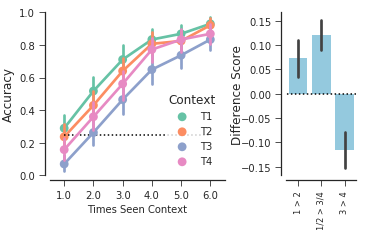

In [23]:
from matplotlib import gridspec



    

# score = pd.concat(score) 

df0 = results[results['In Goal'] & (results.Context >= 7) ].copy()
df0['Context'] += 1

with sns.axes_style('ticks'):
    fig  = plt.figure(figsize=(5.5, 3.0))
    gs = gridspec.GridSpec(1, 2, width_ratios=[2.5, 1], wspace=0.5, hspace=0.6)
    axes = [plt.subplot(gs[0]), plt.subplot(gs[1])]
    
    sns.pointplot(x = 'Times Seen Context', hue='Context', y='Reward', # units='Iteration',
                   data=df0[df0.Model=='Meta'],  palette='Set2', ax=axes[0])
    
    ax = axes[0]
    handles, labels = ax.get_legend_handles_labels()
    handles[0].set_label('T1')
    handles[1].set_label('T2')
    handles[2].set_label('T3')
    handles[3].set_label('T4')
    legend = ax.legend(title="Context", loc='lower right', frameon=1)
    legend.get_frame().set_edgecolor('w')
    ax.get_legend().get_title().set_fontsize(12)
    
    
    # plot difference scores on the right
    sns.barplot(x='Comparison', y='Difference Score', 
            data=score[score.Model == 'Meta'], color='skyblue', ax=axes[1])
    
    ax = axes[0]
    ax.set_ylabel(r'Accuracy',  fontdict={'size':12})
    ax.plot([0, 5], [0.25, 0.25], 'k:')
    ax.set_ylim([0, 1])

    sns.despine(offset=5)

    ax = axes[1]
    ax.set_ylabel(r'Difference Score', labelpad=-3, fontdict={'size':12})
    ax.set_xlabel('')
    ax.plot([-1, 3], [0, 0], 'k:')
    plt.sca(ax)
    plt.xticks([0, 1, 2], [r'1 > 2', u'1/2 > 3/4', r'3 > 4' ], rotation='vertical',
              fontsize='small')
        
    plt.savefig('Exp2_fig3.png', dpi=300)

In [ ]:
with sns.axes_style('ticks'):
    fig, ax  = plt.subplots(figsize=(1.0, 2.5))    # plot difference scores on the right
    sns.barplot(x='Comparison', y='Difference Score', units='Iteration',
            data=score[score.Model == 'Meta'], color='skyblue', ax=ax)
    ax.set_ylabel(r'Difference Score', labelpad=-3, fontdict={'size':12})
    ax.set_xlabel('')
    ax.plot([-1, 3], [0, 0], 'k:')
    ax.set_ylim([-0.2, 0.251])
    ax.set_yticks(np.arange(-0.2, 0.251, 0.1))
    sns.despine(offset=5)
    
    plt.xticks([0, 1, 2], [r'1 > 2', u'1/2 > 3/4', r'3 > 4' ], rotation='vertical')
    ax.set_title(r'Meta')

    plt.savefig('Exp2_fig_model3.png', dpi=300, bbox_inches='tight')

In [ ]:
df0 = results_wMeta[results_wMeta['In Goal'] & (results.Context > 6) & 
               (results_wMeta['Times Seen Context'] == 1) 
             & (results_wMeta['Model'] != 'Flat')].copy()
df0['Map'] = ['1'] * len(df0)
df0.loc[(df0.Context == 7) | (df0.Context == 8), 'Map'] = 1
df0.loc[(df0.Context == 9) | (df0.Context == 10), 'Map'] = 2

cmap = "BrBG"
n = 3
# cc = [sns.color_palette(cmap, n_colors=16)[n], sns.color_palette(cmap, n_colors=16)[-(1+n)]]
cc = sns.color_palette('muted')
df0['Chosen'] = [1] * len(df0)

def plot_f_choice(model, model_name, map_):
    with sns.axes_style('ticks'):
        fig, ax = plt.subplots(1, 1, sharey=True, figsize=(1.5, 2.0))

        cc = [sns.color_palette('muted')[0], sns.color_palette('muted')[2]]
        sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                    data=df0[(df0.Model == model) & (df0.Map == map_)], ax=ax, 
                    color=cc[map_-1])

        ax.set_ylabel('Times Chosen')
        ax.set_xlabel('Goal')
        ax.set_title(model_name)
        ax.set_yticks([0,50,100])
        ax.set_ylim([0, 125])

        sns.despine(offset=5)
        plt.subplots_adjust(wspace=0.4, hspace=0.4)

        plt.tight_layout()
    return fig
fig = plot_f_choice('Independent', 'Indep.', 1)
#     plt.savefig('exp2_qual1_meta.png', dpi=300, bbox_inches='tight')

Plot the model responsibilities over time

In [ ]:
with sns.axes_style('ticks'):

    df0 = results_wMeta[(results_wMeta['Steps Taken']==1) & 
                  (results_wMeta['Model'] == 'Meta')
                 ].copy()

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    ax = axes[0]
    x = range(1, int(df0['Trial Number'].max()) + 2)
    y = df0.groupby('Trial Number')['Joint Probability'].mean()
    y_err = df0.groupby('Trial Number')['Joint Probability'].std() / np.sqrt(n_sims)
    ax.plot(x, y, 'k-')
    ax.fill_between(x, y-y_err, y+y_err, alpha=0.25, color='k')
    ax.set_ylabel('Probability of Joint Agent as Actor')
    ax.set_xlabel('Trial')
    xlb, xub = ax.get_xlim()
    ax.plot([xlb, xub], [0.5, 0.5], 'k:', alpha=0.75)
    ax.set_xlim(xlb, xub)
    ax.set_ylim([0.25, 0.75])

    ax = axes[1]
    y = df0.groupby('Trial Number')['Ind Weight'].mean()
    y_err = df0.groupby('Trial Number')['Ind Weight'].std() / np.sqrt(n_sims)
    ax.plot(x, y, 'r-')
    ax.fill_between(x, y-y_err, y+y_err, alpha=0.2, color='r')

    y = df0.groupby('Trial Number')['Joint Weight'].mean()
    y_err = df0.groupby('Trial Number')['Joint Weight'].std() / np.sqrt(n_sims)
    ax.plot(x, y, '-')
    ax.fill_between(x, y-y_err, y+y_err, alpha=0.2)
    plt.legend(loc='best')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Unnormalized log Posterior')    
    ax.set_xlim(xlb, xub)

    plt.subplots_adjust(hspace=0.3)
    sns.despine()
    plt.savefig('Exp2_fig4.png', dpi=300)

In [ ]:
df0 = results_wMeta[results_wMeta['In Goal'] & (results_wMeta.Context > 6) & 
               (results_wMeta['Times Seen Context'] == 1) 
             & (results_wMeta['Model'] != 'Flat')].copy()
df0['Map'] = ['1'] * len(df0)
df0.loc[(df0.Context == 7) | (df0.Context == 8), 'Map'] = 1
df0.loc[(df0.Context == 9) | (df0.Context == 10), 'Map'] = 2

cc = sns.color_palette('muted')
with sns.axes_style('ticks'):
    df0['Chosen'] = [1] * len(df0)
    fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(2.5, 5))
    
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Meta') & (df0.Map == 2)], ax=axes[0], color=cc[2])
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Meta') & (df0.Map == 1)], ax=axes[1], color=cc[0]) 
    
    for ii in [0, 1]:
        ax = axes[ii]
        ax.set_ylabel('Times Chosen')

    ax = axes[1]
    ax.set_xlabel('Goal')
    
    ax = axes[0]
    ax.set_xlabel('')

    sns.despine(offset=5)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.tight_layout()
    plt.savefig('Exp2_fig5.png', dpi=300)

In [ ]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 1, sharey=True, figsize=(2.0, 2.5))

    cc = sns.color_palette('muted')
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Meta') & (df0.Map == 2)], ax=ax, color=cc[2])
    
    ax.set_ylabel('Times Chosen')
    ax.set_xlabel('Goal')
    ax.set_title(r'Meta')
    ax.set_yticks([0,50,100])
    ax.set_ylim([0, 125])

    sns.despine(offset=5)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    plt.tight_layout()
    plt.savefig('exp2_qual1_meta.png', dpi=300, bbox_inches='tight')

In [ ]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(1, 1, sharey=True, figsize=(2.0, 2.5))

    cc = sns.color_palette('muted')
    sns.barplot(x="Chosen Goal", y="Chosen", order='A B C D'.split(), estimator=np.sum,
                data=df0[(df0.Model == 'Meta') & (df0.Map == 1)], ax=ax, color=cc[0])
    
    ax.set_ylabel('Times Chosen')
    ax.set_xlabel('Goal')
    ax.set_title(r'Meta')
    ax.set_yticks([0,50,100])
    ax.set_ylim([0, 125])

    sns.despine(offset=5)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    
    plt.tight_layout()
    plt.savefig('exp2_qual2_meta.png', dpi=300, bbox_inches='tight')

In [ ]:
results_wMeta.to_pickle('Experiment3sim.pkl')

In [ ]:
n_sims = 250

# alpha is sample from the distribution
# log(alpha) ~ N(alpha_mu, alpha_scale)
alpha_mu = 0.0
alpha_scale = 1.0

inv_temp = 2.5
goal_prior = 10e-20 
prunning_threshold = 10.0
evaluate = True

np.random.seed(11223344)

# pre generate a set of tasks for consistency. 
list_tasks = [gen_task_param() for _ in range(n_sims)]

# pre draw the alphas for consistency
list_alpha = [np.exp(scipy.random.normal(loc=alpha_mu, scale=alpha_scale)) 
              for _ in range(n_sims)]

def sim_agent(AgentClass, name='None',flat=False):
    results = []
    for ii, (task_args, task_kwargs) in tqdm(enumerate(list_tasks), total=len(list_tasks)):

        if not flat:
            agent_kwargs = dict(alpha=list_alpha[ii], inv_temp=inv_temp, 
                                goal_prior=goal_prior)
        else:
            agent_kwargs = dict(inv_temp=inv_temp, goal_prior=goal_prior)
        
        agent = AgentClass(Experiment(*task_args, **task_kwargs), **agent_kwargs)
        
        _res = agent.generate(evaluate=evaluate, prunning_threshold=prunning_threshold)
        _res[u'Model'] = name
        _res[u'Iteration'] = [ii] * len(_res)
        results.append(_res)
    return pd.concat(results)

In [ ]:
results_meta2 = sim_agent(MetaAgent, name='Meta')

In [ ]:
from matplotlib import gridspec

# plot the difference scores
df0 = results_meta2[results_meta2['In Goal'] & (results_meta2.Context >= 7) ].copy()

score = list()
for m in set(df0.Model):
    for it in set(df0.Iteration):
        subj_df = df0.loc[(df0.Model == m) & (df0.Iteration == it), :]
                
        diff_1 = subj_df.loc[subj_df.Context == 7, :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 8) | (subj_df.Context == 10), :].groupby('Times Seen Context').mean()['Acc']

        diff_2 = subj_df.loc[(subj_df.Context == 7) | (subj_df.Context == 8), :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 9) | (subj_df.Context == 10), :].groupby('Times Seen Context').mean()['Acc']

        diff_3 = subj_df.loc[subj_df.Context == 9, :].groupby('Times Seen Context').mean()['Acc'] - \
            subj_df.loc[(subj_df.Context == 8) | (subj_df.Context == 10), :].groupby('Times Seen Context').mean()['Acc']


        n = len(diff_1)
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T1 vs T2'] * n,
                    'Difference Score': diff_1,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T1+2 vs T3+4'] * n,
                    'Difference Score': diff_2,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))
        score.append(pd.DataFrame({
                    'Trials in Context': range(n),
                    'Comparison': ['T3 vs T4'] * n,
                    'Difference Score': diff_3,
                    'Iteration': [it] * n,
                    'Model': [m] * n,
            }))

score = pd.concat(score) 

with sns.axes_style('ticks'):
    fig, ax  = plt.subplots(figsize=(1.0, 2.5))    # plot difference scores on the right
    sns.barplot(x='Comparison', y='Difference Score', units='Iteration',
            data=score[score.Model == 'Meta'], color='skyblue', ax=ax)
    ax.set_ylabel(r'Difference Score', labelpad=-3, fontdict={'size':12})
    ax.set_xlabel('')
    ax.plot([-1, 3], [0, 0], 'k:')
    ax.set_ylim([-0.2, 0.251])
    ax.set_yticks(np.arange(-0.2, 0.251, 0.1))
    sns.despine(offset=5)
    
    plt.xticks([0, 1, 2], [r'1 > 2', u'1/2 > 3/4', r'3 > 4' ], rotation='vertical')
    ax.set_title(r'Meta')